Generate 200 chebyshev sensors on [0, 1]


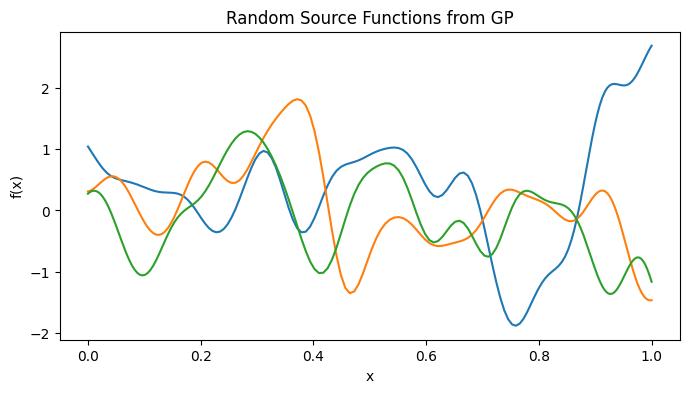

In [16]:
import numpy as np
# device = ("cuda" if torch.cuda.is_available()
#           else "mps" if getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available()
#           else "cpu")
dtype = torch.float32 if device == "mps" else torch.float64


def cheb_sensors(m, a=-1.0, b=1.0):
    print(f"Generate {m+1} chebyshev sensors on [{a}, {b}]")
    """
    Generate Chebyshev nodes scaled to the interval [a, b].

    Parameters:
        m (int): Number of nodes (m+1 points will be generated).
        a (float): Left endpoint of the interval.
        b (float): Right endpoint of the interval.
        dtype: Torch data type.
        device: Torch device.
    
    Returns:
        torch.Tensor: Chebyshev nodes in [a, b].
    """
    j = torch.arange(m + 1, dtype=dtype)
    xi = torch.cos(j * math.pi / m)  # nodes in [-1, 1]
    
    # Scale from [-1, 1] to [a, b]
    scaled_xi = 0.5 * (b - a) * xi + 0.5 * (b + a)
    return scaled_xi.to(torch.float32)
    
def squared_exponential_kernel(x, y, length_scale=0.1):
    """Compute the squared-exponential (RBF) kernel between points x and y."""
    return np.exp(-np.linalg.norm(x - y)**2 / (2 * length_scale**2))

def sample_gp_functions(num_functions=5, num_points=100, domain=(0, 1), length_scale=0.1):
    """
    Sample random functions from a Gaussian Process with squared-exponential kernel.
    
    Parameters:
        num_functions: Number of random functions to generate.
        num_points: Number of discretization points in the domain.
        domain: Tuple (a, b) defining the domain.
        length_scale: Kernel length scale (controls oscillation).
    
    Returns:
        X: Array of shape (num_points,) with domain points.
        functions: Array of shape (num_functions, num_points) with sampled functions.
    """
    # Discretize the domain
    # X = np.linspace(domain[0], domain[1], num_points)

    # Discretize the domain
    X = cheb_sensors(num_points-1, a=domain[0], b=domain[1])
    # Build covariance matrix using the kernel
    K = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i, num_points):  # Only upper triangle
            val = squared_exponential_kernel(np.array([X[i]]), np.array([X[j]]), length_scale)
            K[i, j] = val
            K[j, i] = val  # Mirror to lower triangle

    
    # Add small jitter for numerical stability
    K += 1e-8 * np.eye(num_points)
    
    # Sample from multivariate normal
    functions = np.random.multivariate_normal(mean=np.zeros(num_points), cov=K, size=num_functions)
    
    return X, functions

# Example usage
X, funcs = sample_gp_functions(num_functions=3, num_points=200, length_scale=0.05)

# Plot the sampled functions
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
for f in funcs:
    plt.plot(X, f)
plt.title("Random Source Functions from GP")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()


In [5]:
len(X)

200

In [8]:
len(funcs[0])

200

In [2]:

import torch
import math

def cheb_nodes(m, a=-1.0, b=1.0, dtype=torch.float32, device='cpu'):
    """
    Generate Chebyshev nodes scaled to the interval [a, b].
    
    Parameters:
        m (int): Number of nodes (m+1 points will be generated).
        a (float): Left endpoint of the interval.
        b (float): Right endpoint of the interval.
        dtype: Torch data type.
        device: Torch device.
    
    Returns:
        torch.Tensor: Chebyshev nodes in [a, b].
    """
    j = torch.arange(m + 1, dtype=dtype, device=device)
    xi = torch.cos(j * math.pi / m)  # nodes in [-1, 1]
    
    # Scale from [-1, 1] to [a, b]
    scaled_xi = 0.5 * (b - a) * xi + 0.5 * (b + a)
    return scaled_xi.to(torch.float32)

# Example usage:
nodes = cheb_nodes(m=10, a=0.0, b=2.0)
print(nodes)


tensor([2.0000, 1.9511, 1.8090, 1.5878, 1.3090, 1.0000, 0.6910, 0.4122, 0.1910,
        0.0489, 0.0000])


In [3]:
cheb_nodes(m=10)

tensor([ 1.0000e+00,  9.5106e-01,  8.0902e-01,  5.8779e-01,  3.0902e-01,
        -4.3711e-08, -3.0902e-01, -5.8779e-01, -8.0902e-01, -9.5106e-01,
        -1.0000e+00])

In [20]:

import torch

a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

Q = 3*a**3 - b**2
external_grad = torch.tensor([1., 1.])

# First backward
Q.backward(gradient=external_grad)
print("After first backward:")
print("a.grad:", a.grad)
print("b.grad:", b.grad)

# Second backward without zeroing
Q.backward(gradient=external_grad)
print("\nAfter second backward (accumulated):")
print("a.grad:", a.grad)
print("b.grad:", b.grad)

# Reset gradients and backward again
a.grad.zero_()
b.grad.zero_()
Q.backward(gradient=external_grad)
print("\nAfter zeroing and backward:")
print("a.grad:", a.grad)


After first backward:
a.grad: tensor([36., 81.])
b.grad: tensor([-12.,  -8.])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [18]:
9*a**2

tensor([36., 81.], grad_fn=<MulBackward0>)

In [ ]:
loss_pde = mse(Y_exact, Y_hat)
loss_bc = mse(u_eval[0], torch.tensor([0.0], device=device)) + mse(u_eval[-1], torch.tensor([0.0], device=device))
loss = loss_pde + loss_bc